In [36]:
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
import os

In [37]:
class TextRedactor:
    def __init__(self, languages=['en','hi']):
        """
        Initialize the EasyOCR Reader.
        - languages: List of languages to detect (e.g., ['en', 'hi'])
        - gpu: Set to True if you have a GPU (recommended for speed)
        """
        print(f"Initializing Aegis OCR Engine for languages: {languages}...")
        # Note: The first run will download model weights (~100MB)
        self.reader = easyocr.Reader(languages, gpu=True) 

    def load_image(self, image_path):
        """Loads an image for processing."""
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image at {image_path}")
        return img

    def detect_text(self, image):
        """
        Detects text and returns bounding boxes and actual text content.
        Returns: List of dicts [{'box': [x1, y1, x2, y2], 'text': '...', 'conf': 0.9}]
        """
        # EasyOCR returns: [([[x,y],[x,y],[x,y],[x,y]], text, confidence), ...]
        results = self.reader.readtext(image)
        
        detections = []
        for (bbox, text, prob) in results:
            # Convert EasyOCR's 4-point polygon to a standard x1, y1, x2, y2 box
            (tl, tr, br, bl) = bbox
            x1 = int(min(tl[0], bl[0]))
            y1 = int(min(tl[1], tr[1]))
            x2 = int(max(tr[0], br[0]))
            y2 = int(max(br[1], bl[1]))
            
            detections.append({
                "box": [x1, y1, x2, y2],
                "text": text,
                "conf": prob
            })
        return detections

    def auto_redact(self, image, detections, min_conf=0.2):
        """
        Automatically blurs all detected text regions.
        """
        final_img = image.copy()
        count = 0
        
        for det in detections:
            if det['conf'] >= min_conf:
                x1, y1, x2, y2 = det['box']
                self._blur_region(final_img, x1, y1, x2, y2)
                count += 1
        
        print(f"Redacted {count} text regions.")
        return final_img

    def plot_preview(self, image, detections):
        """Displays the image with identified text for verification."""
        display_img = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
        
        for det in detections:
            x1, y1, x2, y2 = det['box']
            cv2.rectangle(display_img, (x1, y1), (x2, y2), (255, 255, 0), 2)
            # Annotate with the detected text (helpful for debugging)
            cv2.putText(display_img, f"{det['text']}", (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        plt.figure(figsize=(15, 10))
        plt.imshow(display_img)
        plt.title(f"OCR Detection: {len(detections)} text blocks found")
        plt.axis('off')
        plt.show()

    def _blur_region(self, image, x1, y1, x2, y2):
        """Internal helper to apply heavy blur to text areas."""
        # Ensure coordinates are within image boundaries
        h, w = image.shape[:2]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        
        roi = image[y1:y2, x1:x2]
        if roi.size > 0:
            # Kernel size based on text height to ensure it's unreadable
            text_h = y2 - y1
            k_size = text_h if text_h % 2 != 0 else text_h + 1
            k_size = max(25, k_size) # Minimum blur floor
            
            image[y1:y2, x1:x2] = cv2.GaussianBlur(roi, (k_size, k_size), 30)

    def save_image(self, image, filename, folder_path="assets/savedImages"):
        """Saves the processed image."""
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        full_path = os.path.join(folder_path, filename)
        cv2.imwrite(full_path, image)
        print(f"Text-redacted image saved to: {full_path}")
        return full_path



In [38]:
t_redactor = TextRedactor()

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Initializing Aegis OCR Engine for languages: ['en', 'hi']...


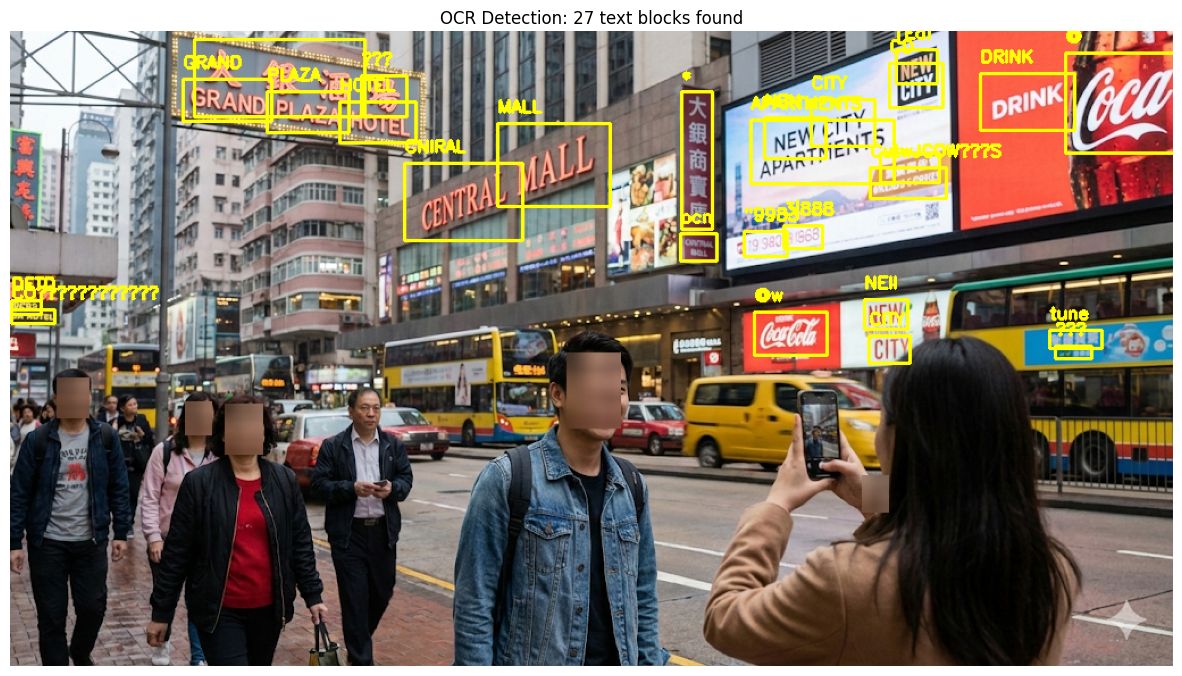

In [39]:
img = t_redactor.load_image('assets/savedImages/blur_face_7062857.png')
detections = t_redactor.detect_text(img)
t_redactor.plot_preview(img, detections)

Redacted 16 text regions.


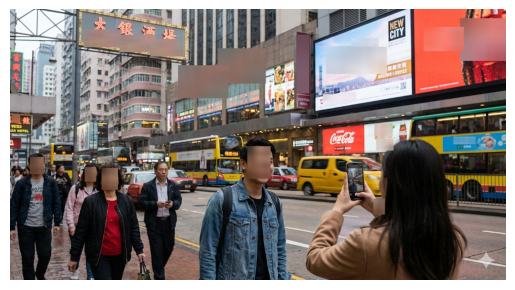

In [40]:
redacted_img = t_redactor.auto_redact(img, detections)
plt.imshow(cv2.cvtColor(redacted_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()